# **Scraping Highlights Page from PDF Files**

In [1]:
!pip install requests requests-toolbelt pdfplumber

!apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 702.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 19.3 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ub

In [2]:
import requests
from requests.adapters import HTTPAdapter, Retry
import lxml.html as lx
import re
import pdfplumber
import csv
from io import BytesIO
import time
import pytesseract

# Create a session with retries and exponential backoff
session = requests.Session()
retries = Retry(
    total=5,                          # Total number of retries
    backoff_factor=1,                 # Wait 1s, 2s, 4s, etc. between retries
    status_forcelist=[502, 503, 504],   # Retry on these HTTP status codes
    allowed_methods=["HEAD", "GET", "OPTIONS"]
)
adapter = HTTPAdapter(max_retries=retries)
session.mount("http://", adapter)
session.mount("https://", adapter)

def safe_get(url, **kwargs):
    """
    Fetch URL using session with retries and exponential backoff.
    If all attempts fail, raises an Exception.
    """
    for attempt in range(5):
        try:
            response = session.get(url, timeout=10, **kwargs)
            response.raise_for_status()
            return response
        except requests.exceptions.RequestException as e:
            wait = 2 ** attempt
            print(f"Error fetching {url}: {e}. Retrying in {wait} seconds...")
            time.sleep(wait)
    raise Exception(f"Failed to fetch {url} after multiple attempts.")

def extract_year_quarter(pdf_url):
    """
    Extract year and quarter from the PDF URL filename.
    Supports both patterns:
      - 'TSLA-Q<digit>-<year>-Update...' or 'TSLA-Q<digit>-<year>-Quarterly-Update'
      - 'TSLA_Update_Letter_<year>-<digit>Q'
    Returns (year, quarter) if found.
    """
    # Try TSLA-Q variant first.
    m = re.search(r'TSLA-(Q[1-4])-(\d{4})', pdf_url)
    if m:
        return m.group(2), m.group(1)
    # Else, try the Update Letter variant.
    m = re.search(r'TSLA_Update_Letter_(\d{4})-([1-4]Q)', pdf_url)
    if m:
        return m.group(1), m.group(2)
    return None, None

def parse_highlights_page(page):
    """
    Crop page 3 into left and right columns, then parse:
      - Left column: 'Profitability', 'Cash', 'Operations'
      - Right column: 'Summary'
    Returns a dict with keys: 'Profitability', 'Cash', 'Operations', 'Summary'.
    If the text extraction returns empty, OCR is applied.
    """
    page_width = page.width
    page_height = page.height

    # Split the page vertically at the midpoint
    midpoint = page_width / 2

    # Define bounding boxes for left and right columns
    left_bbox = (0, 0, midpoint, page_height)
    right_bbox = (midpoint, 0, page_width, page_height)

    # Crop the page into left and right columns
    left_crop = page.crop(bbox=left_bbox)
    right_crop = page.crop(bbox=right_bbox)

    # Extract text from each column; if empty, use OCR.
    left_text = left_crop.extract_text()
    if not left_text or left_text.strip() == "":
        left_image = left_crop.to_image(resolution=300).original
        left_text = pytesseract.image_to_string(left_image)
    right_text = right_crop.extract_text()
    if not right_text or right_text.strip() == "":
        right_image = right_crop.to_image(resolution=300).original
        right_text = pytesseract.image_to_string(right_image)

    # Initialize result dictionary
    sections = {
        "Profitability": "",
        "Cash": "",
        "Operations": "",
        "Summary": right_text.strip()
    }

    # Remove literal "S U M M A R Y" if present in the Summary text
    sections["Summary"] = sections["Summary"].replace("S U M M A R Y", "").strip()

    # Parse left_text for "Profitability", "Cash", "Operations"
    pattern = re.compile(r'(Profitability|Cash|Operations)', re.IGNORECASE)
    parts = re.split(pattern, left_text)

    # Map any matched heading (case-insensitive) to the canonical keys
    heading_map = {
        'profitability': 'Profitability',
        'cash': 'Cash',
        'operations': 'Operations'
    }

    current_heading = None
    for part in parts:
        part = part.strip()
        lower_part = part.lower()
        if lower_part in heading_map:
            current_heading = heading_map[lower_part]
        elif current_heading:
            sections[current_heading] += part + " "

    # Clean up extra spaces in each section
    for key in sections:
        sections[key] = sections[key].strip()

    return sections

def main():
    base_url = "https://ir.tesla.com"

    # Step 1: Fetch the HTML content from the base URL
    response = safe_get(base_url)
    html_content = response.text

    # Parse the HTML using lxml
    doc = lx.fromstring(html_content)

    # Compile regex patterns once for performance
    url_pattern = re.compile(
        r'((?:TSLA-(?:Q[1-4]-\d{4}-(?:Update(?:-\d+)?|Quarterly-Update))|TSLA_Update_Letter_\d{4}-[1-4]Q))(\.pdf)?$',
        re.IGNORECASE
    )
    year_pattern = re.compile(r'(\d{4})')

    pdf_links = []

    # Step 2: Extract PDF links from the "Shareholder Deck" column
    # Find all <td> elements with class 'tcl-table__data-cell'
    td_elements = doc.xpath("//td[contains(@class, 'tcl-table__data-cell')]")
    for td in td_elements:
        style = td.get("style", "")
        if "Shareholder Deck" in style:
            # Find the <a> element with class 'tds-link'
            a_tags = td.xpath(".//a[contains(@class, 'tds-link')]")
            if a_tags:
                href = a_tags[0].get("href", "").strip()
                if url_pattern.search(href):
                    m = year_pattern.search(href)
                    if m and 2020 <= int(m.group(1)) <= 2024:
                        pdf_links.append(href)

    print("Found PDF links for Shareholder Deck between 2020 and 2024:")
    for link in pdf_links:
        print(link)

    rows = []

    # Step 3: Download each qualifying PDF and parse page 3
    for link in pdf_links:
        print(f"\nProcessing PDF: {link}")
        try:
            pdf_resp = safe_get(link)
        except Exception as e:
            print(f"Failed to download PDF from {link}: {e}")
            continue

        pdf_file = BytesIO(pdf_resp.content)
        try:
            with pdfplumber.open(pdf_file) as pdf:
                if len(pdf.pages) < 3:
                    print(f"PDF does not have 3 pages. Skipping: {link}")
                    continue

                # Extract page 3 (index=2)
                page3 = pdf.pages[2]

                # Parse the columns on page 3 (using OCR if necessary)
                sections = parse_highlights_page(page3)

                year, quarter = extract_year_quarter(link)
                data_row = {
                    "Profitability": sections.get("Profitability", ""),
                    "Cash": sections.get("Cash", ""),
                    "Operations": sections.get("Operations", ""),
                    "Summary": sections.get("Summary", ""),
                    "Year": year,
                    "Quarter": quarter
                }
                rows.append(data_row)
        except Exception as e:
            print(f"Error processing PDF {link}: {e}")
            continue

    # Step 4: Write the extracted data to a CSV file.
    csv_filename = "tesla_shareholder_deck_data.csv"
    with open(csv_filename, mode='w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ["Profitability", "Cash", "Operations", "Summary", "Year", "Quarter"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for row in rows:
            writer.writerow(row)

    print(f"\nData successfully saved to '{csv_filename}'")

if __name__ == "__main__":
    main()


Found PDF links for Shareholder Deck between 2020 and 2024:
https://digitalassets.tesla.com/tesla-contents/image/upload/IR/TSLA-Q4-2024-Update.pdf
https://digitalassets.tesla.com/tesla-contents/image/upload/IR/TSLA-Q3-2024-Update.pdf
https://digitalassets.tesla.com/tesla-contents/image/upload/IR/TSLA-Q2-2024-Update.pdf
https://digitalassets.tesla.com/tesla-contents/image/upload/IR/TSLA-Q1-2024-Update.pdf
https://digitalassets.tesla.com/tesla-contents/image/upload/IR/TSLA-Q4-2023-Update.pdf
https://digitalassets.tesla.com/tesla-contents/image/upload/IR/TSLA-Q3-2023-Update-3.pdf
https://digitalassets.tesla.com/tesla-contents/image/upload/IR/TSLA-Q2-2023-Update.pdf
https://digitalassets.tesla.com/tesla-contents/image/upload/IR/TSLA-Q1-2023-Update
https://digitalassets.tesla.com/tesla-contents/image/upload/IR/TSLA-Q4-2022-Update
https://digitalassets.tesla.com/tesla-contents/image/upload/IR/TSLA-Q3-2022-Update
https://digitalassets.tesla.com/tesla-contents/image/upload/IR/TSLA-Q2-2022-Upda

# **Numerical and Textual analysis on the Scrapped Data**

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Data Preview:
                                       Profitability  \
0  $7.1B GAAP operating income in 2024; $1.6B in ...   
1  $2.7B GAAP operating income in Q3\n$2.2B GAAP ...   
2  $1.6B GAAP operating income in Q2 after restru...   
3  $1.2B GAAP operating income in Q1\n$1.1B GAAP ...   
4  $8.9B GAAP operating income in 2023; $2.1B in ...   

                                                Cash  \
0  Operating flow of $14.9B in 2024; $4.8B in Q4\...   
1  Operating flow of $6.3B in Q3\nFree flow2 of $...   
2  Operating flow of $3.6B in Q2\nFree flow2 of $...   
3  Operating flow of $0.2B in Q1\nFree flow2 of n...   
4  tax benefit of $5.9B recorded in Q4 for the\nr...   

                                          Operations  \
0  Increased AI training compute by over 400% in ...   
1  Increased AI training compute by over 75% in Q...   
2  Record energy storage deployment of 9.4 GWh in...   
3  Increased AI training compute by more than 130...   
4  Model Y became the best-selli

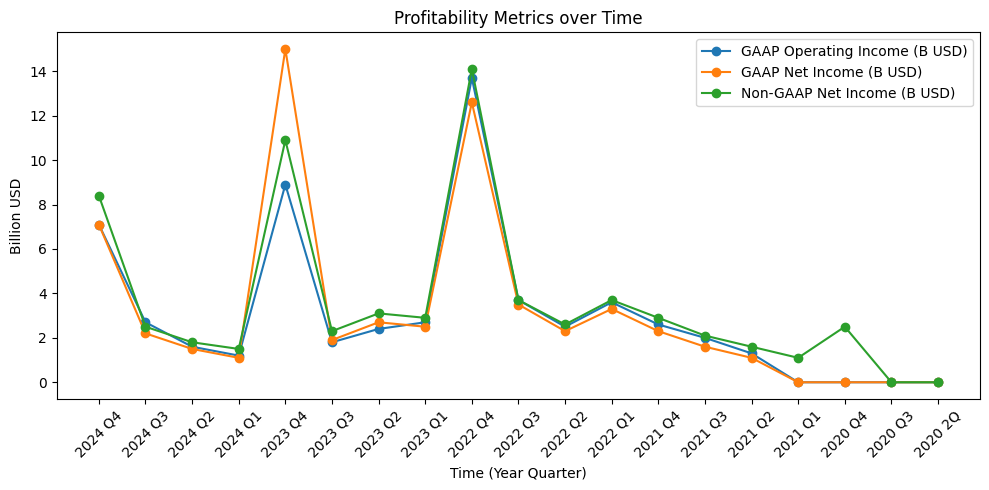

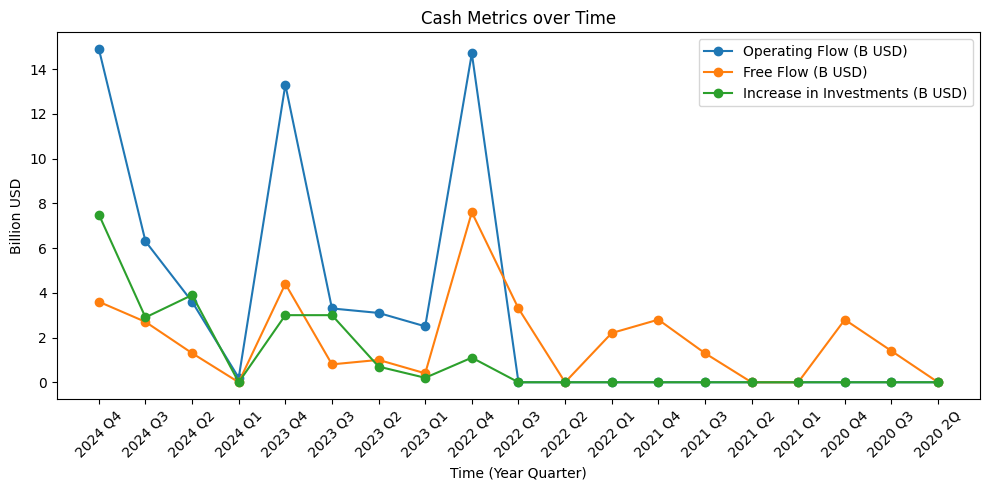

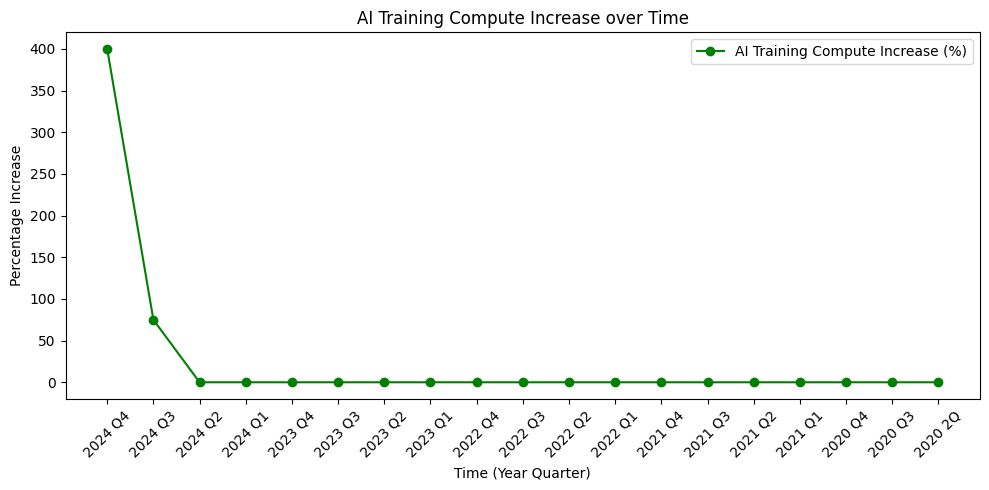

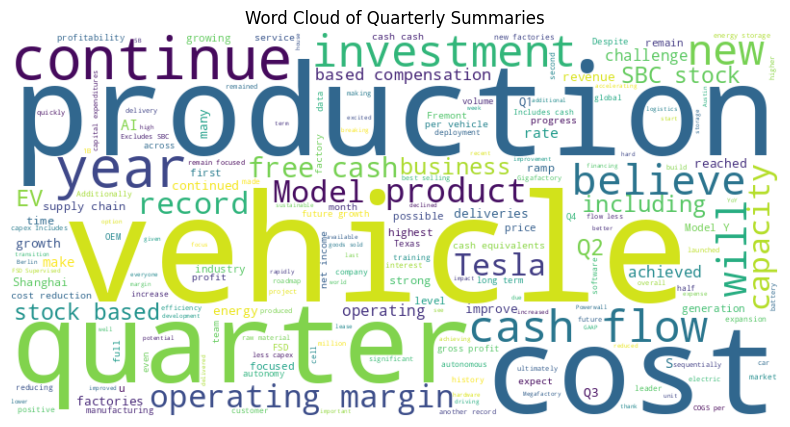


Keywords extracted from each quarter's summary:
Year 2024 Q4: ['record', 'quarter', 'vehicle', 'deliveries', 'energy', 'storage', 'deployments', 'expect', 'model', 'vehicle', 'kind', 'globally', 'full', 'year', 'made', 'even', 'better', 'new', 'model', 'launched', 'markets', 'made', 'significant', 'investments', 'infrastructure', 'spur', 'next', 'wave', 'growth', 'company', 'including', 'vehicle', 'manufacturing', 'capabilities', 'new', 'models', 'ai', 'training', 'compute', 'energy', 'storage', 'manufacturing', 'capacity', 'affordability', 'remains', 'top', 'mind', 'customers', 'continue', 'review', 'every', 'aspect', 'cost', 'goods', 'sold', 'cogs', 'per', 'help', 'alleviate', 'concern', 'cogs', 'per', 'vehicle', 'reached', 'lowest', 'level', 'ever', 'driven', 'largely', 'raw', 'material', 'cost', 'improvement', 'helping', 'us', 'partially', 'offset', 'investment', 'compelling', 'financing', 'lease', 'options', 'energy', 'business', 'achieved', 'another', 'record', 'gross', 'profit'

In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter

# Download necessary NLTK data packages
nltk.download('punkt')
nltk.download('stopwords')
# Attempt to download optional 'punkt_tab' (if needed)
try:
    nltk.download('punkt_tab')
except Exception as e:
    print("Optional resource 'punkt_tab' could not be downloaded:", e)

# Step 1: Load the CSV file and drop the last row
df = pd.read_csv("/content/tesla_shareholder_deck_data.csv")
df = df.iloc[:-1]  # Drop the last row of the CSV file

# Replace blank strings with NaN for string columns
df = df.replace(r'^\s*$', pd.NA, regex=True)

print("Data Preview:")
print(df.head())


# Numeric Data Extraction
# --- For the Profitability column ---
def extract_gaap_operating_income(text):
    """
    Extracts GAAP operating income in billions.
    Example pattern: ".1B GAAP operating income" or "$7.1B GAAP operating income"
    """
    match = re.search(r"\$?([\d\.]+)B\s*GAAP operating income", text, flags=re.IGNORECASE)
    if match:
        return float(match.group(1))
    return None

def extract_gaap_net_income(text):
    """
    Extracts GAAP net income in billions.
    Example pattern: "$7.1B GAAP net income"
    """
    match = re.search(r"\$?([\d\.]+)B\s*GAAP net income", text, flags=re.IGNORECASE)
    if match:
        return float(match.group(1))
    return None

def extract_nongaap_net_income(text):
    """
    Extracts non-GAAP net income in billions.
    Example pattern: "$8.4B non-GAAP net income"
    """
    match = re.search(r"\$?([\d\.]+)B\s*non-?GAAP net income", text, flags=re.IGNORECASE)
    if match:
        return float(match.group(1))
    return None

# --- For the Cash column ---
def extract_operating_flow(text):
    """
    Extracts operating flow in billions.
    Example pattern: "Operating flow of $14.9B"
    """
    match = re.search(r"Operating flow of \$?([\d\.]+)B", text, flags=re.IGNORECASE)
    if match:
        return float(match.group(1))
    return None

def extract_free_flow(text):
    """
    Extracts free flow in billions.
    Example pattern: "Free flow.*of $3.6B"
    """
    match = re.search(r"Free flow.*of \$?([\d\.]+)B", text, flags=re.IGNORECASE)
    if match:
        return float(match.group(1))
    return None

def extract_increase_in_investments(text):
    """
    Extracts the increase in investments in billions.
    Example pattern: "$7.5B increase in our and investments"
    """
    match = re.search(r"\$?([\d\.]+)B\s*increase in our and investments", text, flags=re.IGNORECASE)
    if match:
        return float(match.group(1))
    return None

# --- For the Operations column ---
def extract_ai_training_compute_increase(text):
    """
    Extracts the percentage increase in AI training compute.
    Example pattern: "Increased AI training compute by over 400%"
    """
    match = re.search(r"Increased AI training compute by over\s*(\d+)%", text, flags=re.IGNORECASE)
    if match:
        return float(match.group(1))
    return None

# Apply extraction functions to the appropriate columns
# For numeric extractions, if the text is missing, the lambda returns None; later we fill those with 0.

# From Profitability column:
df['GAAP_Operating_Income'] = df['Profitability'].apply(lambda x: extract_gaap_operating_income(x) if pd.notnull(x) else None)
df['GAAP_Net_Income']       = df['Profitability'].apply(lambda x: extract_gaap_net_income(x) if pd.notnull(x) else None)
df['Non_GAAP_Net_Income']   = df['Profitability'].apply(lambda x: extract_nongaap_net_income(x) if pd.notnull(x) else None)

# From Cash column:
df['Operating_Flow']         = df['Cash'].apply(lambda x: extract_operating_flow(x) if pd.notnull(x) else None)
df['Free_Flow']              = df['Cash'].apply(lambda x: extract_free_flow(x) if pd.notnull(x) else None)
df['Increase_in_Investments'] = df['Cash'].apply(lambda x: extract_increase_in_investments(x) if pd.notnull(x) else None)

# From Operations column:
df['AI_Training_Compute_Increase'] = df['Operations'].apply(lambda x: extract_ai_training_compute_increase(x) if pd.notnull(x) else None)

# Fill missing numeric values with 0
numeric_cols = ['GAAP_Operating_Income', 'GAAP_Net_Income', 'Non_GAAP_Net_Income',
                'Operating_Flow', 'Free_Flow', 'Increase_in_Investments', 'AI_Training_Compute_Increase']
df[numeric_cols] = df[numeric_cols].fillna(0)

# Create a combined time label for plotting (Year + Quarter)
df['Time_Label'] = df['Year'].astype(str) + " " + df['Quarter']

print("\nExtracted Numeric Data:")
print(df[['Year', 'Quarter', 'GAAP_Operating_Income', 'GAAP_Net_Income', 'Non_GAAP_Net_Income',
          'Operating_Flow', 'Free_Flow', 'Increase_in_Investments', 'AI_Training_Compute_Increase']].head())


# Plot Profitability metrics
plt.figure(figsize=(10, 5))
plt.plot(df['Time_Label'], df['GAAP_Operating_Income'], marker='o', label='GAAP Operating Income (B USD)')
plt.plot(df['Time_Label'], df['GAAP_Net_Income'], marker='o', label='GAAP Net Income (B USD)')
plt.plot(df['Time_Label'], df['Non_GAAP_Net_Income'], marker='o', label='Non-GAAP Net Income (B USD)')
plt.xticks(rotation=45)
plt.xlabel("Time (Year Quarter)")
plt.ylabel("Billion USD")
plt.title("Profitability Metrics over Time")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Cash metrics
plt.figure(figsize=(10, 5))
plt.plot(df['Time_Label'], df['Operating_Flow'], marker='o', label='Operating Flow (B USD)')
plt.plot(df['Time_Label'], df['Free_Flow'], marker='o', label='Free Flow (B USD)')
plt.plot(df['Time_Label'], df['Increase_in_Investments'], marker='o', label='Increase in Investments (B USD)')
plt.xticks(rotation=45)
plt.xlabel("Time (Year Quarter)")
plt.ylabel("Billion USD")
plt.title("Cash Metrics over Time")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Operations metric: AI Training Compute Increase
plt.figure(figsize=(10, 5))
plt.plot(df['Time_Label'], df['AI_Training_Compute_Increase'], marker='o', color='green', label='AI Training Compute Increase (%)')
plt.xticks(rotation=45)
plt.xlabel("Time (Year Quarter)")
plt.ylabel("Percentage Increase")
plt.title("AI Training Compute Increase over Time")
plt.legend()
plt.tight_layout()
plt.show()


# Text Analysis on Summary Column

# Generate a word cloud from all summary texts
text_data = " ".join(df["Summary"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Quarterly Summaries")
plt.show()

# Extract keywords for each quarter using tokenization and stopword removal
stop_words = set(stopwords.words('english'))

def get_keywords(text):
    """
    Tokenizes the text, converts tokens to lowercase, and removes non-alphabetic tokens and stopwords.
    """
    words = nltk.word_tokenize(text)
    words = [w.lower() for w in words if w.isalpha() and w.lower() not in stop_words]
    return words

df['Keywords'] = df['Summary'].apply(lambda x: get_keywords(x) if pd.notnull(x) else pd.NA)

print("\nKeywords extracted from each quarter's summary:")
for idx, row in df.iterrows():
    print(f"Year {row['Year']} {row['Quarter']}: {row['Keywords']}")
